# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
#tf.logging.set_verbosity(tf.logging.ERROR)

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [2]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [3]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [4]:
df = df.iloc[:, 1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [5]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [6]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [7]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [8]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state = 10)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [10]:
def get_model(): 
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss = 'mse',
        optimizer = 'adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [11]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.4500 - val_loss: 1.4373
Epoch 2/1000
149/149 [==============================] - 0s 875us/step - loss: 1.4441 - val_loss: 1.4312
Epoch 3/1000
149/149 [==============================] - 0s 915us/step - loss: 1.4381 - val_loss: 1.4249
Epoch 4/1000
149/149 [==============================] - 0s 895us/step - loss: 1.4320 - val_loss: 1.4186
Epoch 5/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.4257 - val_loss: 1.4121
Epoch 6/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.4195 - val_loss: 1.4057
Epoch 7/1000
149/149 [==============================] - 0s 952us/step - loss: 1.4133 - val_loss: 1.3994
Epoch 8/1000
149/149 [==============================] - 0s 899us/step - loss: 1.4071 - val_loss: 1.3930
Epoch 9/1000
149/149 [==============================] - 0s 883us/step - loss: 1.4009 - val_loss: 1.3867
Epoch 10/1000
149/149 [==============================] - 0s 901us/step

149/149 [==============================] - 0s 886us/step - loss: 1.1154 - val_loss: 1.0985
Epoch 80/1000
149/149 [==============================] - 0s 885us/step - loss: 1.1131 - val_loss: 1.0962
Epoch 81/1000
149/149 [==============================] - 0s 817us/step - loss: 1.1108 - val_loss: 1.0939
Epoch 82/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1086 - val_loss: 1.0917
Epoch 83/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1063 - val_loss: 1.0895
Epoch 84/1000
149/149 [==============================] - 0s 886us/step - loss: 1.1041 - val_loss: 1.0873
Epoch 85/1000
149/149 [==============================] - 0s 882us/step - loss: 1.1019 - val_loss: 1.0851
Epoch 86/1000
149/149 [==============================] - 0s 828us/step - loss: 1.0997 - val_loss: 1.0829
Epoch 87/1000
149/149 [==============================] - 0s 849us/step - loss: 1.0975 - val_loss: 1.0808
Epoch 88/1000
149/149 [==============================] - 0s 836us/step - 

Epoch 157/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9965 - val_loss: 0.9824
Epoch 158/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9956 - val_loss: 0.9816
Epoch 159/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9947 - val_loss: 0.9807
Epoch 160/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9937 - val_loss: 0.9799
Epoch 161/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9928 - val_loss: 0.9790
Epoch 162/1000
149/149 [==============================] - 0s 959us/step - loss: 0.9919 - val_loss: 0.9782
Epoch 163/1000
149/149 [==============================] - 0s 984us/step - loss: 0.9910 - val_loss: 0.9773
Epoch 164/1000
149/149 [==============================] - 0s 949us/step - loss: 0.9901 - val_loss: 0.9765
Epoch 165/1000
149/149 [==============================] - 0s 987us/step - loss: 0.9893 - val_loss: 0.9757
Epoch 166/1000
149/149 [==============================] 

Epoch 235/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9436 - val_loss: 0.9335
Epoch 236/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9431 - val_loss: 0.9330
Epoch 237/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9425 - val_loss: 0.9325
Epoch 238/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9420 - val_loss: 0.9320
Epoch 239/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9415 - val_loss: 0.9315
Epoch 240/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9410 - val_loss: 0.9310
Epoch 241/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9405 - val_loss: 0.9306
Epoch 242/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9400 - val_loss: 0.9301
Epoch 243/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9395 - val_loss: 0.9296
Epoch 244/1000
149/149 [==============================] - 0s 1ms

149/149 [==============================] - 0s 1ms/step - loss: 0.9059 - val_loss: 0.8982
Epoch 314/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9054 - val_loss: 0.8978
Epoch 315/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9049 - val_loss: 0.8973
Epoch 316/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9044 - val_loss: 0.8969
Epoch 317/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9040 - val_loss: 0.8964
Epoch 318/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9035 - val_loss: 0.8960
Epoch 319/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9030 - val_loss: 0.8955
Epoch 320/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9025 - val_loss: 0.8950
Epoch 321/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9021 - val_loss: 0.8946
Epoch 322/1000
149/149 [==============================] - 0s 1ms/step - loss: 0

149/149 [==============================] - 0s 1ms/step - loss: 0.8674 - val_loss: 0.8603
Epoch 392/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8669 - val_loss: 0.8597
Epoch 393/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8663 - val_loss: 0.8592
Epoch 394/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8658 - val_loss: 0.8587
Epoch 395/1000
149/149 [==============================] - 0s 938us/step - loss: 0.8653 - val_loss: 0.8582
Epoch 396/1000
149/149 [==============================] - 0s 950us/step - loss: 0.8648 - val_loss: 0.8577
Epoch 397/1000
149/149 [==============================] - 0s 933us/step - loss: 0.8643 - val_loss: 0.8572
Epoch 398/1000
149/149 [==============================] - 0s 936us/step - loss: 0.8637 - val_loss: 0.8567
Epoch 399/1000
149/149 [==============================] - 0s 962us/step - loss: 0.8632 - val_loss: 0.8562
Epoch 400/1000
149/149 [==============================] - 0s 921us/st

Epoch 469/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8245 - val_loss: 0.8175
Epoch 470/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8239 - val_loss: 0.8170
Epoch 471/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8233 - val_loss: 0.8164
Epoch 472/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8227 - val_loss: 0.8158
Epoch 473/1000
149/149 [==============================] - 0s 970us/step - loss: 0.8222 - val_loss: 0.8152
Epoch 474/1000
149/149 [==============================] - 0s 947us/step - loss: 0.8216 - val_loss: 0.8146
Epoch 475/1000
149/149 [==============================] - 0s 946us/step - loss: 0.8210 - val_loss: 0.8140
Epoch 476/1000
149/149 [==============================] - 0s 952us/step - loss: 0.8204 - val_loss: 0.8134
Epoch 477/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8198 - val_loss: 0.8128
Epoch 478/1000
149/149 [==============================] 

149/149 [==============================] - 0s 988us/step - loss: 0.7776 - val_loss: 0.7688
Epoch 548/1000
149/149 [==============================] - 0s 923us/step - loss: 0.7769 - val_loss: 0.7681
Epoch 549/1000
149/149 [==============================] - 0s 973us/step - loss: 0.7763 - val_loss: 0.7675
Epoch 550/1000
149/149 [==============================] - 0s 917us/step - loss: 0.7757 - val_loss: 0.7668
Epoch 551/1000
149/149 [==============================] - 0s 938us/step - loss: 0.7750 - val_loss: 0.7662
Epoch 552/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7744 - val_loss: 0.7655
Epoch 553/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7738 - val_loss: 0.7648
Epoch 554/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7731 - val_loss: 0.7642
Epoch 555/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7725 - val_loss: 0.7635
Epoch 556/1000
149/149 [==============================] - 0s 1ms/step

Epoch 625/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7270 - val_loss: 0.7169
Epoch 626/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7263 - val_loss: 0.7162
Epoch 627/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7257 - val_loss: 0.7155
Epoch 628/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7250 - val_loss: 0.7148
Epoch 629/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7243 - val_loss: 0.7142
Epoch 630/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7236 - val_loss: 0.7135
Epoch 631/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7230 - val_loss: 0.7128
Epoch 632/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7223 - val_loss: 0.7121
Epoch 633/1000
149/149 [==============================] - 0s 957us/step - loss: 0.7216 - val_loss: 0.7114
Epoch 634/1000
149/149 [==============================] - 0s 9

149/149 [==============================] - 0s 1ms/step - loss: 0.6742 - val_loss: 0.6640
Epoch 703/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6735 - val_loss: 0.6633
Epoch 704/1000
149/149 [==============================] - 0s 988us/step - loss: 0.6728 - val_loss: 0.6626
Epoch 705/1000
149/149 [==============================] - 0s 977us/step - loss: 0.6721 - val_loss: 0.6619
Epoch 706/1000
149/149 [==============================] - 0s 945us/step - loss: 0.6714 - val_loss: 0.6612
Epoch 707/1000
149/149 [==============================] - 0s 921us/step - loss: 0.6707 - val_loss: 0.6605
Epoch 708/1000
149/149 [==============================] - 0s 971us/step - loss: 0.6700 - val_loss: 0.6598
Epoch 709/1000
149/149 [==============================] - 0s 977us/step - loss: 0.6693 - val_loss: 0.6591
Epoch 710/1000
149/149 [==============================] - 0s 957us/step - loss: 0.6686 - val_loss: 0.6585
Epoch 711/1000
149/149 [==============================] - 0s 916u

Epoch 780/1000
149/149 [==============================] - 0s 990us/step - loss: 0.6181 - val_loss: 0.6091
Epoch 781/1000
149/149 [==============================] - 0s 992us/step - loss: 0.6174 - val_loss: 0.6083
Epoch 782/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6166 - val_loss: 0.6076
Epoch 783/1000
149/149 [==============================] - 0s 993us/step - loss: 0.6159 - val_loss: 0.6069
Epoch 784/1000
149/149 [==============================] - 0s 985us/step - loss: 0.6151 - val_loss: 0.6062
Epoch 785/1000
149/149 [==============================] - 0s 980us/step - loss: 0.6144 - val_loss: 0.6055
Epoch 786/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6136 - val_loss: 0.6047
Epoch 787/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6129 - val_loss: 0.6040
Epoch 788/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6122 - val_loss: 0.6033
Epoch 789/1000
149/149 [==============================

Epoch 858/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5602 - val_loss: 0.5527
Epoch 859/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5595 - val_loss: 0.5520
Epoch 860/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5588 - val_loss: 0.5513
Epoch 861/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5581 - val_loss: 0.5506
Epoch 862/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5573 - val_loss: 0.5499
Epoch 863/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5566 - val_loss: 0.5492
Epoch 864/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5559 - val_loss: 0.5484
Epoch 865/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5551 - val_loss: 0.5477
Epoch 866/1000
149/149 [==============================] - 0s 960us/step - loss: 0.5544 - val_loss: 0.5470
Epoch 867/1000
149/149 [==============================] - 0s 9

Epoch 936/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5022 - val_loss: 0.4970
Epoch 937/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5015 - val_loss: 0.4963
Epoch 938/1000
149/149 [==============================] - 0s 977us/step - loss: 0.5007 - val_loss: 0.4955
Epoch 939/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5000 - val_loss: 0.4948
Epoch 940/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4993 - val_loss: 0.4941
Epoch 941/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4985 - val_loss: 0.4934
Epoch 942/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4978 - val_loss: 0.4926
Epoch 943/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4970 - val_loss: 0.4919
Epoch 944/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4963 - val_loss: 0.4912
Epoch 945/1000
149/149 [==============================] - 0s 9

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

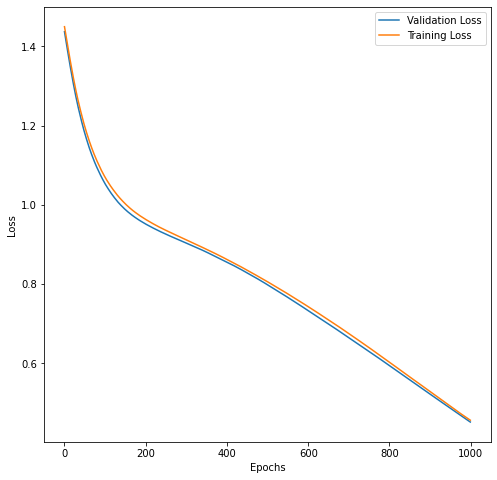

In [12]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

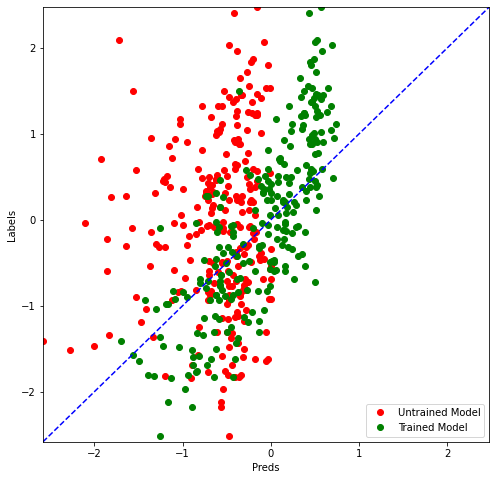

In [13]:
preds_on_trained = model.predict(X_test)
compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

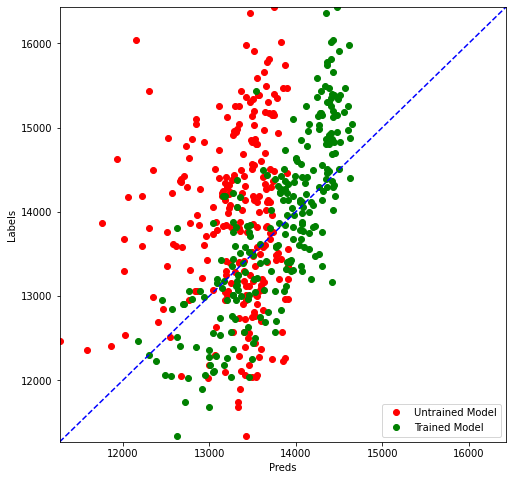

In [14]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)